# Applicability of steady-state assumptions


In [1]:
from __future__ import annotations

from functools import partial
from pathlib import Path

from utils import *

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.contrib.concurrent import process_map

IMG_PATH = Path("results") / "img"
plt.style.use(("seaborn-talk", "seaborn-whitegrid"))  # type: ignore

In [2]:
long_cpd_names = {
    "PQ": "plastoquionone",
    "PC": "plastocyanine",
    "Fd": "ferredoxin",
    "ATP": "ATP",
    "NADPH": "NADPH",
    # "H": "protons",
    # "LHC",
    # "Psbs",
    # "Vx",
    "PGA": "phosphoglycerate",
    "BPGA": "biphosphoglycerate",
    "GAP": "glyceraldehyde 3-phosphate",
    "DHAP": "dihydroxyacetone phosphate",
    "FBP": "fructose-1,6-bisphosphat",
    "F6P": "fructose-6-phosphate",
    "G6P": "glucose-6-phosphate",
    "G1P": "glucose-1-phosphate",
    "SBP": "sedoheptulose-1-7-bisphosphate",
    "S7P": "sedoheptulose-7-phosphate",
    "E4P": "erythrose-4-phosphate",
    "X5P": "xylulose-5-phosphate",
    "R5P": "ribose-5-phosphate",
    "RUBP": "ribulose-biphosphate",
    "RU5P": "ribulose-5-phosphate",
    "MDA": "monodehydroascorbate",
    "H2O2": "peroxide",
    "DHA": "dehydroascorbate",
    "GSSG": "glutathione",
    # "TR_ox": "thioredoxin",
    # "E_inactive",
}

long_rxn_names = {
    # PETC
    "vPS2": "PS2",  # photosystem II
    "vPS1": "PS1",  # photosystem I
    "vPTOX": "plastid terminal oxidase",
    "vNDH": "NAD(P)H dehydrogenase-like complex",
    "vB6f": "Cytochrome b6f complex",
    "vCyc": "cyclic electron flow",
    "vFNR": "Ferredoxin-NADP reductase",
    # "vLeak": "proton leak",
    "vSt12": "PSI-PSII state transition",
    "vSt21": "PSII-PSI state transition",
    "vATPsynthase": "ATP synthase",
    "vDeepox": "Violaxanthin de-epoxidase",
    "vEpox": "Zeaxanthin epoxidase",
    "vLhcprotonation": "LHC protonation",
    "vLhcdeprotonation": "LHC deprotonation",
    # CBB
    "vRuBisCO": "RuBisCO",
    "vPGA_kinase": "phosphoglycerate kinase",
    "vBPGA_dehydrogenase": "glyceraldehyde 3-phosphate dehydrogenase",
    "vTPI": "triose-phosphate isomerase ",
    "vAldolase": "aldolase (FBP)",
    "vFBPase": "fructose-1,6-bisphosphatase",
    "vF6P_Transketolase": "transketolase (F6P)",
    "v8": "aldolase (SBP)",
    "v9": "sbpase",
    "v10": "transketolase (S7P)",
    "v11": "ribose-5-phosphate isomerase",
    "v12": "ribulose-phosphate 3-epimerase",
    "v13": "phosphoribulokinase",
    "vG6P_isomerase": "G6P isomerase",
    "vPhosphoglucomutase": "",
    # "vpga": "Efflux (PGA)",
    # "vgap": "Efflux (GAP)",
    # "vdhap": "Efflux (DHAP)",
    # "vStarch": "",
    # Mehler
    "vFdred": "Ferredoxin reductase",
    "vAscorbate": "ascorbate peroxidase",
    "vMDAreduct": "monodehydroascorbate reductase",
    "vDHAR": "dehydroascorbate reductase",
    "v3ASC": "L-ascorbate peroxidase",
    "vGR": "glutathione reductase",
    "vMehler": "mehler",
    # "vEX_ATP": "",
    # "vEX_NADPH": ""1,
    # "vFdTrReductase": "",
    # "vE_activation": "",
    # "vE_inactivation": "",
}

# Our description of the cycle is represented by four saturating enzymatic reactions
# [mediated by ascorbate peroxidase (APX),
# monodehydroascorbate reductase (MDAR),
# dehydroascorbate reductase (DHAR),
# glutathione reductase (GR)]
# and one spontaneous disproportion of monodehydroascorbate radicals (MDA),

colors = {
    "General": "C0",
    "PETC": "C1",
    "CBB": "C2",
    "Mehler": "C3",
}

## Data

The data are from field observations from MART [Washington state, geographic coordinates (lat/long datum): 45.790835 -121.933788 WGS 84], where the photosynthetically active radiation (PAR) was measured in one minute steps. 


In [3]:
data = Path(".") / "data" / "1min"
data_by_one_minute = pd.concat([pd.read_csv(i) for i in sorted(data.glob("*"))])  # type: ignore
data_by_one_minute.index = pd.to_datetime(data_by_one_minute["startDateTime"].values)
data_by_one_minute = data_by_one_minute["PARMean"].dropna()
data_by_one_minute.index = data_by_one_minute.index.tz_convert("EST")  # type: ignore

# There is some negative data, and for which pfd < 30 model is unstable
data_by_one_minute[data_by_one_minute < 30] = 30

## Part 1: reducing model complexity

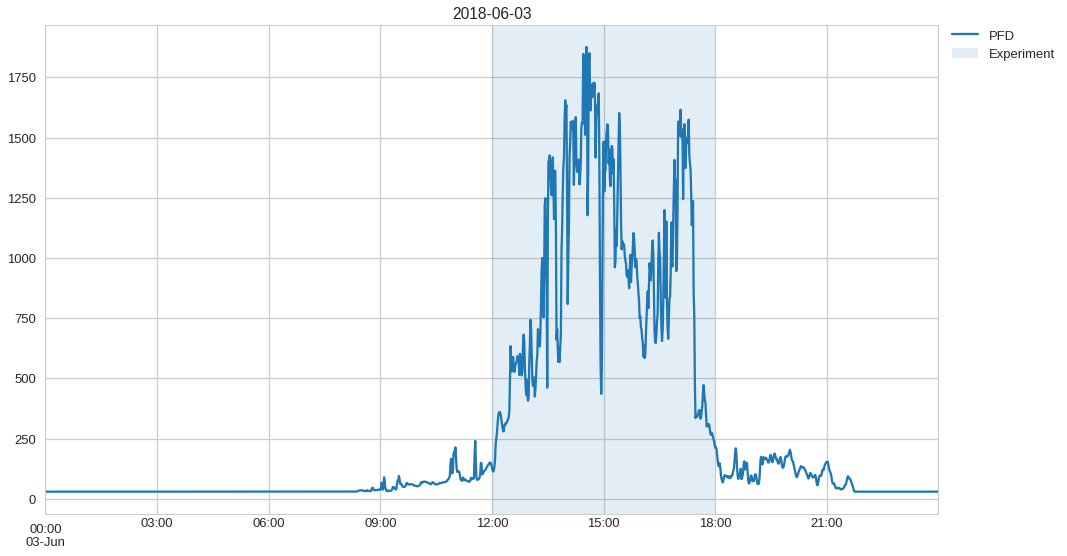

In [4]:
# Choose random date as initial experiment
date = "2018-06-03"
day = data_by_one_minute.loc[f"{date} 00:00":f"{date} 23:59"]
experiment = day.between_time("12:00", "17:59").round(decimals=0)

fig = plot_pfd_of_experiment(experiment, day, date, figsize=(16, 9))
plt.savefig(IMG_PATH / "part1-ppfd.png", bbox_inches="tight", dpi=200)

### Steady-state fluxes explain most of the variation

RuBisCO fluxes vary quite a lot over time, but most of that behaviour is explained by the flux the system would have at steady state with each PFD. There are some large errors, but most seem to wobble around 0.

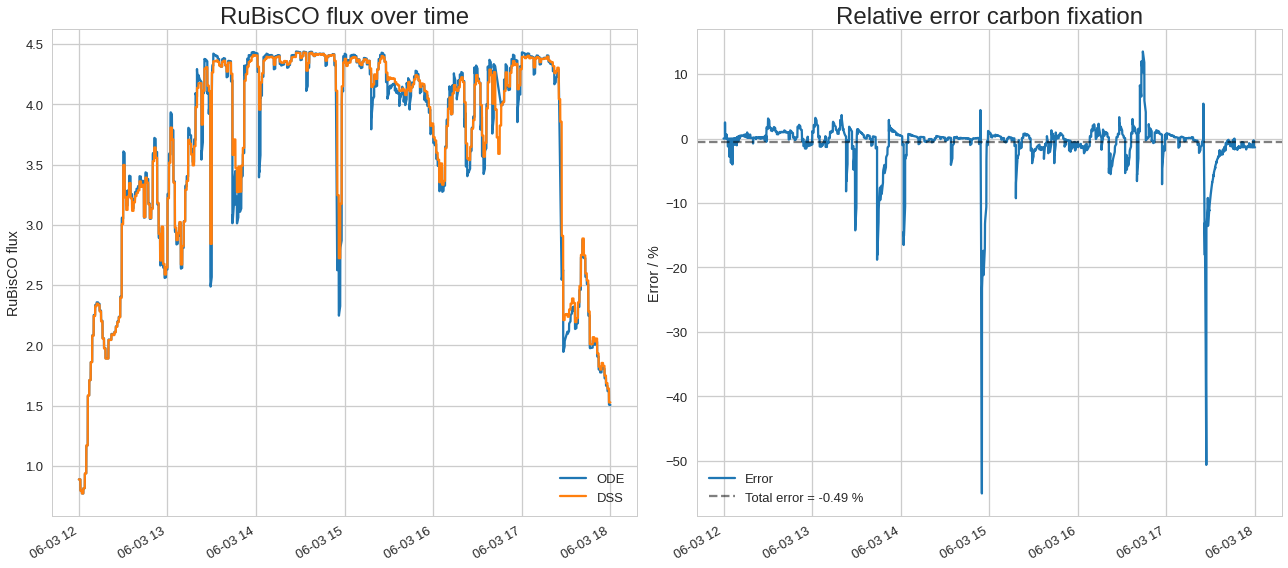

In [5]:
def plot_dss_error_over_time(
    experiment: pd.Series,
    v_ode: pd.DataFrame,
    v_dss: pd.DataFrame,
    axs: Axes | None = None,
    figsize: tuple[float, float] = (16, 6),
) -> tuple[Figure, list[plt.Axes]]:
    def relative(x: pd.Series, y: pd.Series) -> pd.Series:
        return (x - y) * 100 / x

    if axs is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)  # type: ignore
    else:
        ax1, ax2 = axs
        fig = ax1.get_figure()

    x = experiment.index[0] + pd.to_timedelta(v_ode.index, unit="s")

    def plot1(ax: plt.Axes) -> None:
        ax.plot(x, v_ode["vRuBisCO"], color="C0", label="ODE")
        ax.plot(x, v_dss["vRuBisCO"], color="C1", label="DSS")
        ax.set_title("RuBisCO flux over time", fontsize=24)
        ax.set(ylabel="RuBisCO flux")
        ax.legend(loc="lower right")

    def plot2(ax: plt.Axes) -> None:
        diff = relative(v_ode["vRuBisCO"], v_dss["vRuBisCO"])
        ax.plot(x, diff.dropna(), label="Error")
        # mean_error = diff.mean()
        # ax.axhline(
        #     mean_error,
        #     color="black",
        #     alpha=0.5,
        #     linestyle="dashed",
        #     label=f"Mean error = {mean_error:.2f} %",
        # )
        total_error = relative(v_ode["vRuBisCO"].sum(), v_dss["vRuBisCO"].sum())
        ax.axhline(
            total_error,
            color="black",
            alpha=0.5,
            linestyle="dashed",
            label=f"Total error = {total_error:.2f} %",
        )
        ax.set_title("Relative error carbon fixation", fontsize=24)
        ax.set(
            ylabel="Error / %",
        )
        ax.legend(loc="lower left")

    plot1(ax1)
    plot2(ax2)

    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, [ax1, ax2]


y_ss, c_ode, v_ode, ss_concentrations_by_pfd, ss_fluxes_by_pfd = run_experiment(
    experiment
)
v_dss_1 = simulate_dss_with_par(experiment, ss_fluxes_by_pfd, 1)

fig, axs = plot_dss_error_over_time(experiment, v_ode, v_dss_1, figsize=(18, 8))
plt.savefig(IMG_PATH / "part1-flux-over-time.png", bbox_inches="tight", dpi=200)

27 %


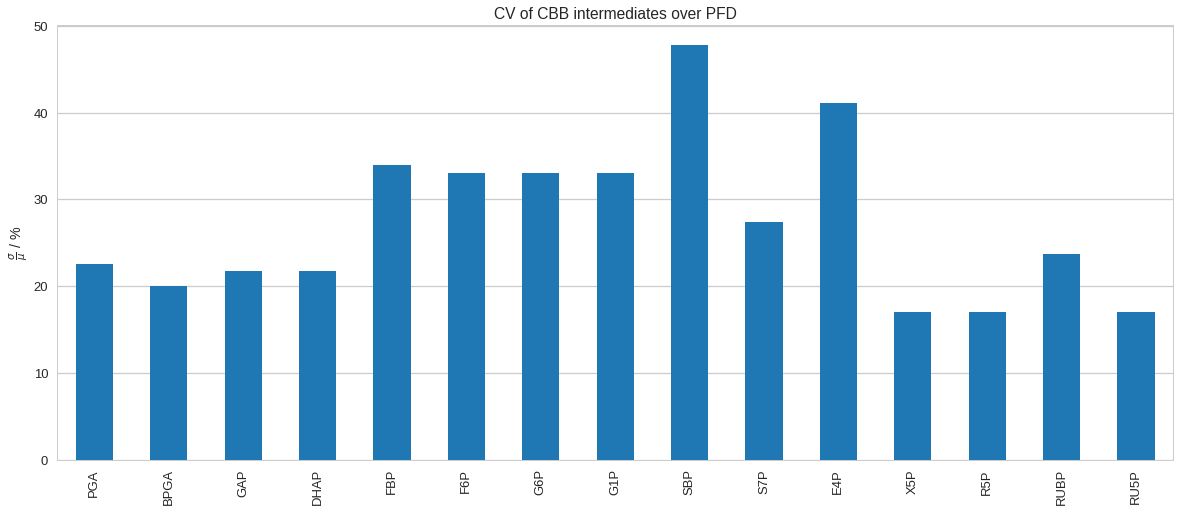

In [6]:
def calvin_cycle_intermediates() -> list[str]:
    return [
        "PGA",
        "BPGA",
        "GAP",
        "DHAP",
        "FBP",
        "F6P",
        "G6P",
        "G1P",
        "SBP",
        "S7P",
        "E4P",
        "X5P",
        "R5P",
        "RUBP",
        "RU5P",
    ]


cci = ss_concentrations_by_pfd[calvin_cycle_intermediates()]
cv = cci.std() * 100 / cci.mean()
print(f"{cv.mean():.0f} %")

fig, ax = plt.subplots(figsize=(20, 8))
cv.plot(
    kind="bar",
    ax=ax,
    ylabel=r"$\frac{\sigma}{\mu}$ / %",
    title="CV of CBB intermediates over PFD",
)
ax.grid(False, axis="x")
plt.savefig(IMG_PATH / "part0-cv-concs-over-pfd.png", bbox_inches="tight", dpi=200)
plt.show()

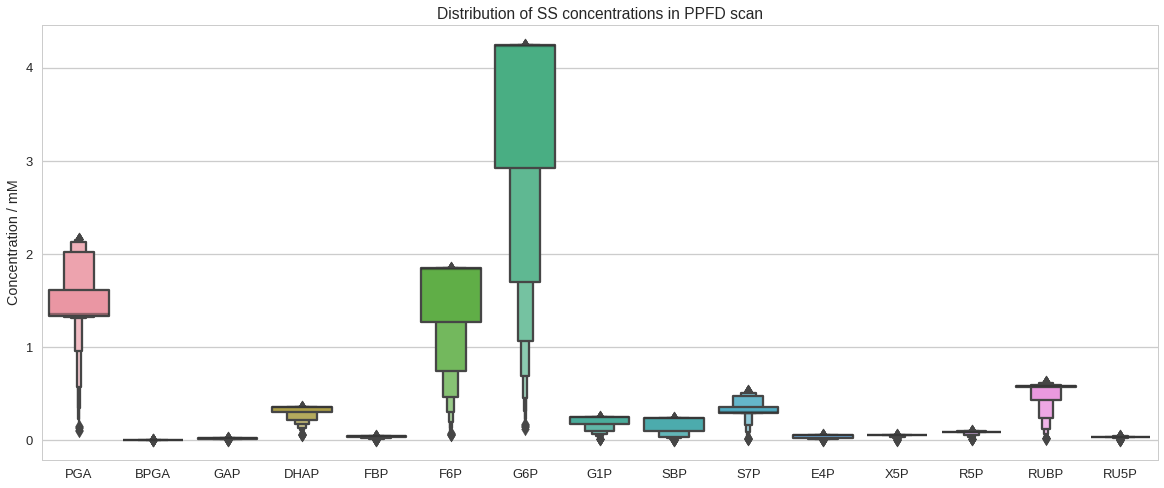

In [206]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.boxenplot(data=cci, ax=ax)
ax.set(
    title="Distribution of SS concentrations in PPFD scan", ylabel="Concentration / mM"
)
plt.savefig(IMG_PATH / "part0-boxenplot-concs-over-pfd.png", bbox_inches="tight", dpi=200)

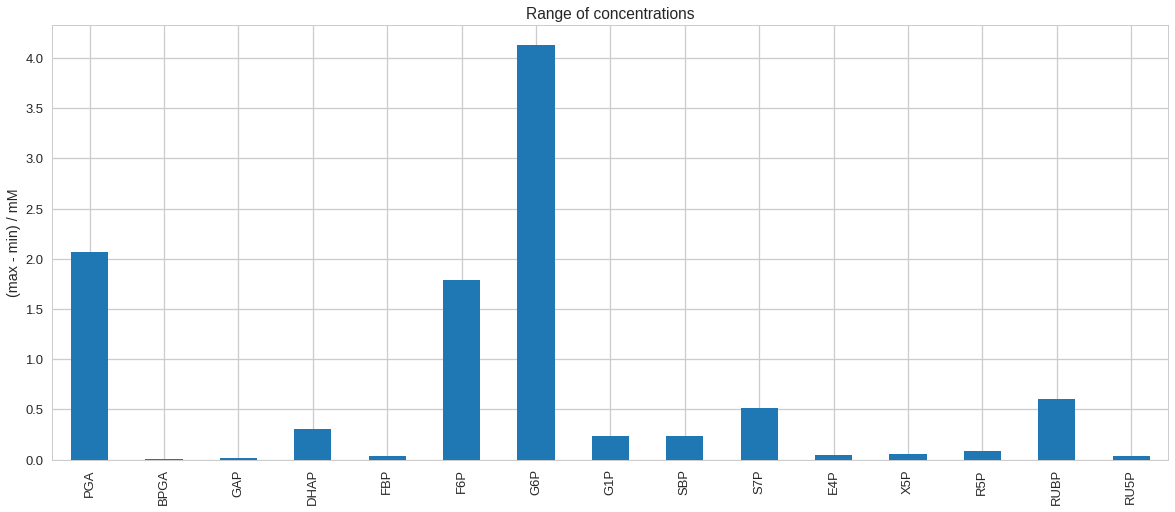

In [203]:
data_range = cci.max() - cci.min()
# data_range / cci.mean()
fig, ax = plt.subplots(figsize=(20, 8))
data_range.plot(
    kind="bar", ylabel="(max - min) / mM", title="Range of concentrations", ax=ax
)
plt.savefig(IMG_PATH / "part0-range-concs-over-pfd.png", bbox_inches="tight", dpi=200)

<AxesSubplot:xlabel='PPFD', ylabel='Fluxes relative to PSII'>

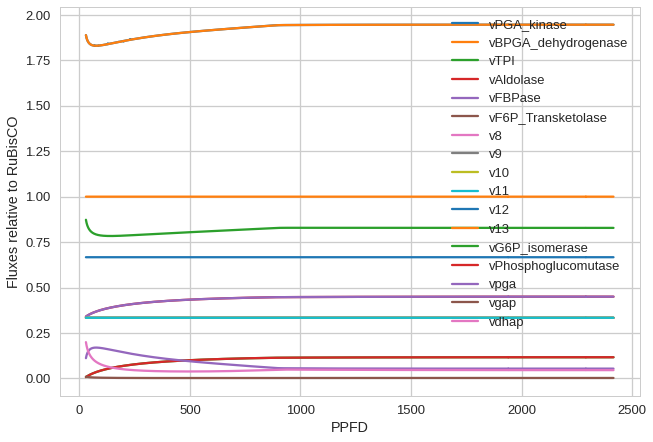

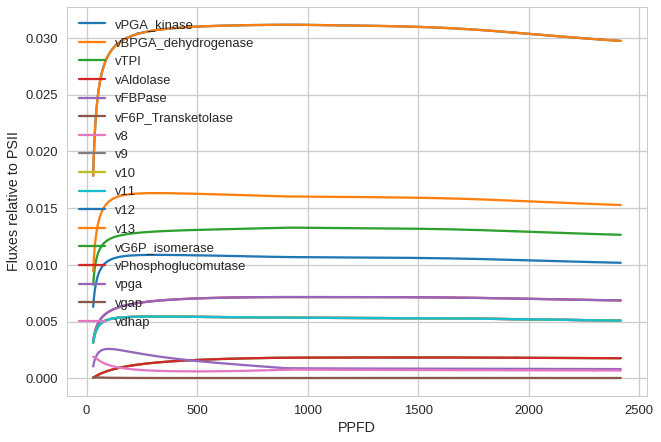

In [204]:
def calvin_cycle_fluxes() -> list[str]:
    return [
        "vRuBisCO",
        "vPGA_kinase",
        "vBPGA_dehydrogenase",
        "vTPI",
        "vAldolase",
        "vFBPase",
        "vF6P_Transketolase",
        "v8",
        "v9",
        "v10",
        "v11",
        "v12",
        "v13",
        "vG6P_isomerase",
        "vPhosphoglucomutase",
        "vpga",
        "vgap",
        "vdhap",
    ]


(
    ss_fluxes_by_pfd[calvin_cycle_fluxes()]
    / ss_fluxes_by_pfd["vRuBisCO"].values.reshape(-1, 1)
).drop(columns="vRuBisCO").plot(xlabel="PPFD", ylabel="Fluxes relative to RuBisCO")


(
    ss_fluxes_by_pfd[calvin_cycle_fluxes()]
    / ss_fluxes_by_pfd["vPS2"].values.reshape(-1, 1)
).drop(columns="vRuBisCO").plot(xlabel="PPFD", ylabel="Fluxes relative to PSII")

In [10]:
# v_dss = v_dss_1

# x = experiment.index[0] + pd.to_timedelta(v_ode.index, unit="s")
# diff = v_ode["vRuBisCO"] - v_dss["vRuBisCO"]
# abs_diff = abs(diff)
# rel_diff = abs_diff / v_ode["vRuBisCO"]

# print(f"Error mean: {diff.mean():.2f}")
# print(f"Error abs mean: {abs(diff).mean():.2f}")
# print(f"Error rel mean: {rel_diff.mean():.2%}")
# print(f"Error std: {diff.std():.2f}")


# print(f"5 % proximity: {sum(rel_diff < 0.05) / len(rel_diff):.2%}")
# print(f"10 % proximity: {sum(rel_diff < 0.1) / len(rel_diff):.2%}")
# print(f"20 % proximity: {sum(rel_diff < 0.2) / len(rel_diff):.2%}")

### Only NPQ / Mehler are badly predicted

What is the absolute error of total carbon fixation rate of the simplified model? 0.49 %.
That's not a lot at all. The only fluxes that are badly predicted are the ones of non-photochemical quenching or the water-water cycle. So our model essentially predicts that the CBB cycle is close to steady state the entire time and that the quenching mechanisms buffer away most disturbances of the system.

In [28]:
set(get_model(0).rates.keys()).difference(
    {
        "vPS2": "PETC",
        "vPS1": "PETC",
        "vPTOX": "PETC",
        "vNDH": "PETC",
        "vB6f": "PETC",
        "vCyc": "PETC",
        "vFNR": "PETC",
        "vSt12": "PETC",
        "vSt21": "PETC",
        "vATPsynthase": "PETC",
        "vDeepox": "PETC",
        "vEpox": "PETC",
        "vLhcprotonation": "PETC",
        "vLhcdeprotonation": "PETC",
        "vRuBisCO": "CBB",
        "vPGA_kinase": "CBB",
        "vBPGA_dehydrogenase": "CBB",
        "vTPI": "CBB",
        "vAldolase": "CBB",
        "vFBPase": "CBB",
        "vF6P_Transketolase": "CBB",
        "v8": "CBB",
        "v9": "CBB",
        "v10": "CBB",
        "v11": "CBB",
        "v12": "CBB",
        "v13": "CBB",
        "vFdred": "Mehler",
        "vAscorbate": "Mehler",
        "vMDAreduct": "Mehler",
        "vDHAR": "Mehler",
        "v3ASC": "Mehler",
        "vGR": "Mehler",
        "vMehler": "Mehler",
    }
)

{'vEX_ATP',
 'vEX_NADPH',
 'vE_activation',
 'vE_inactivation',
 'vFdTrReductase',
 'vG6P_isomerase',
 'vLeak',
 'vPhosphoglucomutase',
 'vStarch',
 'vdhap',
 'vgap',
 'vpga'}

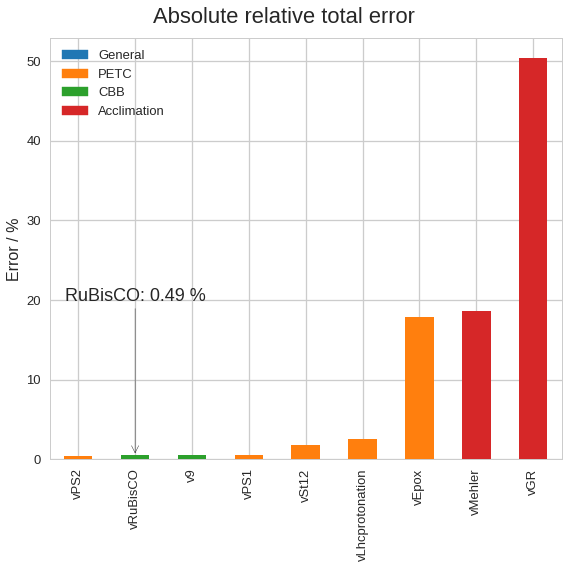

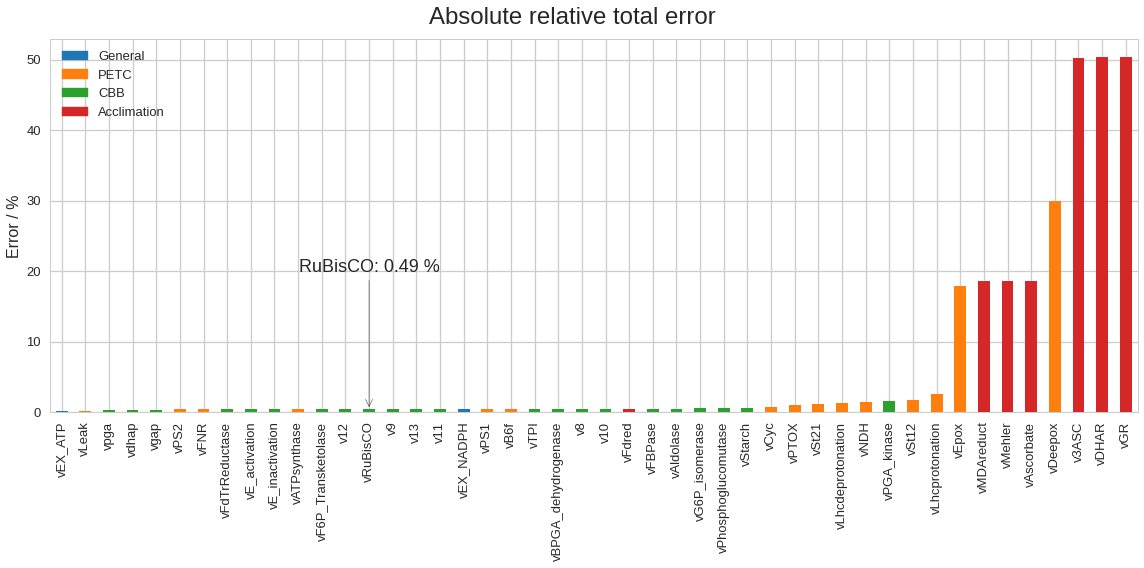

In [47]:
def plot_absolute_total_error_by_metabolite(
    v_ode: pd.DataFrame,
    v_dss: pd.DataFrame,
    colors: dict[str, str],
    selection: list[str] | None = None,
    ax: Axis | None = None,
    figsize: tuple[float, float] = (16, 6),
    title_size: int = 24,
    order: list[str] | None = None,
) -> tuple[Figure, list[str]]:
    def relative(x: pd.Series, y: pd.Series) -> pd.Series:
        return (x - y) * 100 / x

    rxn_color = {
        "vPS2": "PETC",
        "vPS1": "PETC",
        "vPTOX": "PETC",
        "vNDH": "PETC",
        "vB6f": "PETC",
        "vCyc": "PETC",
        "vFNR": "PETC",
        "vSt12": "PETC",
        "vSt21": "PETC",
        "vATPsynthase": "PETC",
        "vDeepox": "PETC",
        "vEpox": "PETC",
        "vLhcprotonation": "PETC",
        "vLhcdeprotonation": "PETC",
        "vRuBisCO": "CBB",
        "vPGA_kinase": "CBB",
        "vBPGA_dehydrogenase": "CBB",
        "vTPI": "CBB",
        "vAldolase": "CBB",
        "vFBPase": "CBB",
        "vF6P_Transketolase": "CBB",
        "v8": "CBB",
        "v9": "CBB",
        "v10": "CBB",
        "v11": "CBB",
        "v12": "CBB",
        "v13": "CBB",
        "vFdred": "Mehler",
        "vAscorbate": "Mehler",
        "vMDAreduct": "Mehler",
        "vDHAR": "Mehler",
        "v3ASC": "Mehler",
        "vGR": "Mehler",
        "vMehler": "Mehler",
        "vEX_ATP": "General",
        "vEX_NADPH": "General",
        "vE_activation": "CBB",
        "vE_inactivation": "CBB",
        "vFdTrReductase": "CBB",
        "vLeak": "PETC",
        "vG6P_isomerase": "CBB",  # starch really
        "vPhosphoglucomutase": "CBB",  # starch really
        "vStarch": "CBB",  # starch really
        "vdhap": "CBB",
        "vgap": "CBB",
        "vpga": "CBB",
    }

    if selection is None:
        selection = list(rxn_color.keys())

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    df = abs(relative(v_ode.sum(), v_dss.sum())).loc[selection]
    if order is None:
        df = df.sort_values(ascending=True)
        order = list(df.index)
    else:
        df = df.loc[order]
    idx = {v: k for k, v in enumerate(df.index)}["vRuBisCO"]
    val = cast(float, df["vRuBisCO"])
    df.plot(ax=ax, kind="bar", color=[colors[rxn_color[i]] for i in df.index])
    ax.annotate(
        f"RuBisCO: {df['vRuBisCO']:.2f} %",
        (idx, val),
        xytext=(idx, val + 20),
        arrowprops={"arrowstyle": "->"},
        **{"va": "center", "ha": "center", "fontsize": 18},
    )
    ax.set_ylabel("Error / %", fontsize=16)
    # ax.set_ylim(0, 100)
    # ax.set_xticklabels([long_rxn_names[i] for i in df.index])

    ax.legend(
        handles=[
            Patch(label=i, color=f"C{j}")
            for j, i in enumerate(["General", "PETC", "CBB", "Acclimation"])
        ]
    )

    fig.suptitle("Absolute relative total error", fontsize=title_size)
    fig.tight_layout()

    return fig, order


rxn_selection = [
    "vPS2",
    "vPS1",
    # "vPTOX",
    # "vNDH",
    # "vB6f",
    # "vCyc",
    # "vFNR",
    # "vATPsynthase",
    "vRuBisCO",
    # "vPGA_kinase",
    # "vBPGA_dehydrogenase",
    # "vTPI",
    # "vAldolase",
    # "vFBPase",
    # "vF6P_Transketolase",
    # "v8",
    "v9",
    # "v10",
    # "v11",
    # "v12",
    # "v13",
    # "vFdred",
    # "vAscorbate",
    # "vMDAreduct",
    "vSt12",
    # "vSt21",
    "vLhcprotonation",
    # "vLhcdeprotonation",
    # "vDeepox",
    "vEpox",
    "vMehler",
    # "v3ASC",
    # "vDHAR",
    "vGR",
]

fig, _ = plot_absolute_total_error_by_metabolite(
    v_ode, v_dss_1, colors, selection=rxn_selection, figsize=(8, 8), title_size=22
)
plt.savefig(
    IMG_PATH / "part1-abs-rel-tot-error-selection.png", bbox_inches="tight", dpi=200
)

fig, _ = plot_absolute_total_error_by_metabolite(v_ode, v_dss_1, colors, figsize=(16, 8))
plt.savefig(IMG_PATH / "part1-abs-rel-tot-error-full.png", bbox_inches="tight", dpi=200)

In [48]:
# fig, order = plot_absolute_total_error_by_metabolite(v_ode, simulate_dss_with_par(experiment, ss_fluxes_by_pfd, 1), colors, figsize=(16, 8))
# plt.savefig(IMG_PATH / "part1-abs-rel-tot-error-full-step01.png", bbox_inches="tight", dpi=200)

# _ = plot_absolute_total_error_by_metabolite(v_ode, simulate_dss_with_par(experiment, ss_fluxes_by_pfd, 2), colors, figsize=(16, 8), order=order)
# plt.savefig(IMG_PATH / "part1-abs-rel-tot-error-full-step02.png", bbox_inches="tight", dpi=200)

# _ = plot_absolute_total_error_by_metabolite(v_ode, simulate_dss_with_par(experiment, ss_fluxes_by_pfd, 5), colors, figsize=(16, 8), order=order)
# plt.savefig(IMG_PATH / "part1-abs-rel-tot-error-full-step05.png", bbox_inches="tight", dpi=200)

# _ = plot_absolute_total_error_by_metabolite(v_ode, simulate_dss_with_par(experiment, ss_fluxes_by_pfd, 10), colors, figsize=(16, 8), order=order)
# plt.savefig(IMG_PATH / "part1-abs-rel-tot-error-full-step10.png", bbox_inches="tight", dpi=200)

# _ = plot_absolute_total_error_by_metabolite(v_ode, simulate_dss_with_par(experiment, ss_fluxes_by_pfd, 20), colors, figsize=(16, 8), order=order)
# plt.savefig(IMG_PATH / "part1-abs-rel-tot-error-full-step20.png", bbox_inches="tight", dpi=200)

# _ = plot_absolute_total_error_by_metabolite(v_ode, simulate_dss_with_par(experiment, ss_fluxes_by_pfd, 30), colors, figsize=(16, 8), order=order)
# plt.savefig(IMG_PATH / "part1-abs-rel-tot-error-full-step30.png", bbox_inches="tight", dpi=200)

# _ = plot_absolute_total_error_by_metabolite(v_ode, simulate_dss_with_par(experiment, ss_fluxes_by_pfd, 60), colors, figsize=(16, 8), order=order)
# plt.savefig(IMG_PATH / "part1-abs-rel-tot-error-full-step60.png", bbox_inches="tight", dpi=200)

In [50]:
def plot_relative_std(
    selection: list[str] | None = None,
    ax: Axis | None = None,
    figsize: tuple[float, float] = (18, 8),
    title_size: int = 24,
):
    cpd_groups = {
        "ATP": "General",
        "NADPH": "General",
        "PC": "PETC",
        "PQ": "PETC",
        "Fd": "PETC",
        "Psbs": "PETC",
        "X5P": "CBB",
        "R5P": "CBB",
        "RU5P": "CBB",
        "RUBP": "CBB",
        "DHAP": "CBB",
        "GAP": "CBB",
        "S7P": "CBB",
        "FBP": "CBB",
        "E4P": "CBB",
        "SBP": "CBB",
        "Vx": "Mehler",
        "H2O2": "Mehler",
        "MDA": "Mehler",
        "GSSG": "Mehler",
        # "E_inactive": "General",  # how much did thioredoxin regulation change? ~ 33 %
    }

    if selection is None:
        selection = list(cpd_groups.keys())

    # coefficient of variation / relative standard deviation
    cv = (c_ode.std() / c_ode.mean())[selection].sort_values() * 100

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    cv.plot(kind="bar", color=[colors[cpd_groups[i]] for i in cv.index], ax=ax)
    ax.set_title("CV of concentrations", fontsize=title_size)
    ax.set_ylabel(r"$\frac{\sigma}{\mu}$ / %", fontsize=16)

    idx = {v: k for k, v in enumerate(cv.index)}["RUBP"]
    val = cast(float, cv["RUBP"])
    ax.annotate(
        f"RuBP: {cv['RUBP']:.0f} %",
        (idx, val),
        xytext=(idx, val + 100),
        arrowprops={"arrowstyle": "->"},
        **{"va": "center", "ha": "center", "fontsize": 18},
    )
    ax.legend(
        handles=[
            Patch(label=i, color=f"C{j}")
            for j, i in enumerate(["General", "PETC", "CBB", "Acclimation"])
        ]
    )
    return fig


cpd_selection = [
    "ATP",
    "NADPH",
    # "PC",
    "PQ",
    # "Psbs",
    # "X5P",
    # "R5P",
    # "RU5P",
    "RUBP",
    # "DHAP",
    # "GAP",
    "S7P",
    "FBP",
    "E4P",
    "SBP",
    "Fd",
    "Vx",
    # "H2O2",
    "MDA",
    "GSSG",
]

fig = plot_relative_std(selection=cpd_selection, figsize=(8, 8), title_size=20)
plt.savefig(IMG_PATH / "part1-rel-std-concs-selection.png", bbox_inches="tight", dpi=200)


fig = plot_relative_std(figsize=(16, 8))
plt.savefig(IMG_PATH / "part1-rel-std-concs-full.png", bbox_inches="tight", dpi=200)

In [12]:
# Paper figure 1

# fig = plt.figure(figsize=(8, 8), constrained_layout=True)
# spec = fig.add_gridspec(2, 2)
# ax0 = fig.add_subplot(spec[0, :])
# ax1 = fig.add_subplot(spec[1, 0])
# ax2 = fig.add_subplot(spec[1, 1])

# fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# plot_dss_error_over_time(experiment, v_ode, v_dss_1, axs=axs[0, :])
# plot_absolute_total_error_by_metabolite(
#     v_ode, v_dss_1, colors, selection=rxn_selection, ax=axs[1, 0],
# )
# plot_relative_std(selection=cpd_selection, ax=axs[1, 1])

In [13]:
def plot_relative_std_fluxes(figsize: tuple[float, float]):
    rxn_selection = {
        "vPS2": "PETC",
        "vPS1": "PETC",
        "vPTOX": "PETC",
        "vNDH": "PETC",
        "vB6f": "PETC",
        "vCyc": "PETC",
        "vFNR": "PETC",
        "vSt12": "PETC",
        "vSt21": "PETC",
        "vATPsynthase": "PETC",
        "vDeepox": "PETC",
        "vEpox": "PETC",
        "vLhcprotonation": "PETC",
        "vLhcdeprotonation": "PETC",
        "vRuBisCO": "CBB",
        "vPGA_kinase": "CBB",
        "vBPGA_dehydrogenase": "CBB",
        "vTPI": "CBB",
        "vAldolase": "CBB",
        "vFBPase": "CBB",
        "vF6P_Transketolase": "CBB",
        "v8": "CBB",
        "v9": "CBB",
        "v10": "CBB",
        "v11": "CBB",
        "v12": "CBB",
        "v13": "CBB",
        "vFdred": "Mehler",
        "vAscorbate": "Mehler",
        "vMDAreduct": "Mehler",
        "vDHAR": "Mehler",
        "v3ASC": "Mehler",
        "vGR": "Mehler",
        "vMehler": "Mehler",
    }
    # coefficient of variation / relative standard deviation
    cv = (v_ode.std() / v_ode.mean()).loc[rxn_selection.keys()].sort_values() * 100

    fig, ax = plt.subplots(figsize=figsize)
    cv.plot(kind="bar", color=[colors[rxn_selection[i]] for i in cv.index], ax=ax)
    idx = {v: k for k, v in enumerate(cv.index)}["vRuBisCO"]
    val = cast(float, cv["vRuBisCO"])
    ax.annotate(
        f"RuBisCO: {cv['vRuBisCO']:.0f} %",
        (idx, val),
        xytext=(idx, val + 100),
        arrowprops={"arrowstyle": "->"},
        **{"va": "center", "ha": "center", "fontsize": 14},
    )
    ax.set(title="Relative standard deviation of fluxes")
    ax.set_ylabel(r"$\frac{\sigma}{\mu}$ / %")
    ax.legend(
        handles=[
            Patch(label=i, color=f"C{j}")
            for j, i in enumerate(["General", "PETC", "CBB", "Acclimation"])
        ]
    )
    return fig


fig = plot_relative_std_fluxes(figsize=(18, 8))
plt.savefig(IMG_PATH / "part1-rel-std-fluxes.png", bbox_inches="tight", dpi=200)

In [14]:
# fig = plot_mehler_ode_vs_dss(v_ode, v_dss_1)
# plt.savefig(IMG_PATH / "fig2_1.png", bbox_inches="tight")

### Carbon fixation rate is MM-like

A scan over the steady-state fluxes of carbon fixation rate in our model shows that the carbon fixation rate depends of the PFD in a michaelis-menten rate equation like fashion, which suggests that the remaining metabolism will behave linearly with that.

In [15]:
def plot_rubisco_flux_by_rubp(
    experiment: pd.Series, figsize: tuple[float, float] = (8, 8)
) -> Figure:
    m = get_model(cast(float, experiment.iloc[0]))
    print(m.parameters["pfd"])
    fcd = m.get_full_concentration_dict(y_ss) | m.get_parameters()

    y_orig = {i: fcd[i] for i in m.rates["vRuBisCO"].args}
    y_scan = y_orig.copy()
    y_scan["RUBP"] = np.linspace(0, 10, 100)

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(y_scan["RUBP"], m.rates["vRuBisCO"].function(*y_scan.values()), label="Flux")
    ax.plot(
        y_orig["RUBP"],
        m.rates["vRuBisCO"].function(*y_orig.values()),
        marker="o",
        color="C1",
        label="Reference concentration",
    )
    ax.set_title("RuBisCO flux by RuBP")
    ax.set_xlabel("RuBP / mM")
    ax.set_ylabel("Flux / (mM / s)")
    ax.legend()
    return fig


_ = plot_rubisco_flux_by_rubp(experiment)
plt.savefig(IMG_PATH / "part1-rubisco-by-rubp.png", bbox_inches="tight", dpi=200)

130.0


In [16]:
fig = plot_ss_rubisco_flux_per_pfd(
    v_ode,
    ss_fluxes_by_pfd,
    experiment,
    min_line=False,
    max_line=False,
    markers=False,
    figsize=(8, 8),
)
plt.savefig(IMG_PATH / "part1-rubisco-by-pfd.png", bbox_inches="tight", dpi=200)

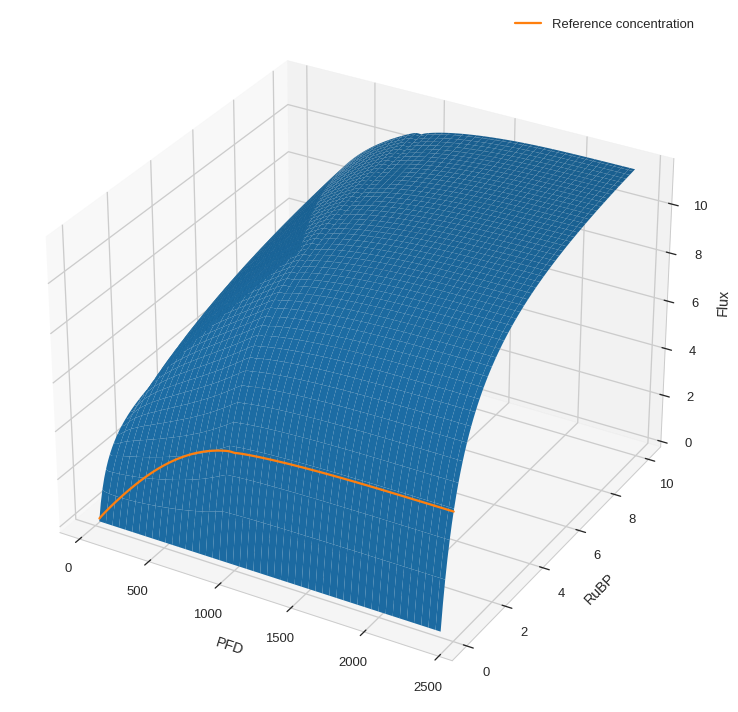

In [17]:
def plot_rubisco_flux_by_rubp_and_pfd(
    experiment: pd.Series,
    ss_concentrations_by_pfd: pd.DataFrame,
    figsize: tuple[float, float] = (8, 8),
) -> Figure:
    m = get_model(cast(float, experiment.iloc[0]))
    fcd = (
        m.get_full_concentration_dict(ss_concentrations_by_pfd.to_numpy())
        | m.get_parameters()
    )
    y_orig = {i: fcd[i] for i in m.rates["vRuBisCO"].args}
    y_scan = y_orig.copy()
    rubp_scan = np.linspace(0, 10, 100).reshape(-1, 1)
    y_scan["RUBP"] = rubp_scan

    figsize = (16, 10)
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": "3d"})

    ax.plot_surface(
        *np.meshgrid(ss_concentrations_by_pfd.index, rubp_scan),
        m.rates["vRuBisCO"].function(*y_scan.values()),
    )
    ax.plot(
        ss_concentrations_by_pfd.index,
        y_orig["RUBP"],
        m.rates["vRuBisCO"].function(*y_orig.values()),
        label="Reference concentration",
    )
    ax.set_xlabel("\n\nPFD")
    ax.set_ylabel("\n\nRuBP")
    ax.set_zlabel("\n\nFlux")
    fig.tight_layout()
    ax.legend()
    return fig


_ = plot_rubisco_flux_by_rubp_and_pfd(experiment, ss_concentrations_by_pfd)
plt.savefig(IMG_PATH / "part1-rubisco-by-rubp-and-pfd.png", bbox_inches="tight", dpi=200)

In [44]:
from modelbase.ode.utils import mca


def scan_response_coefficients_per_pfd(y_ss) -> pd.DataFrame:
    crcs = {}
    frcs = {}
    m = get_model(100)
    for i in np.arange(100, 1500, 100):
        m.update_parameter("pfd", i)
        crc, frc = mca.get_response_coefficients_df(
            m, ["pfd"], m.get_full_concentration_dict(y_ss)
        )
        crcs[i] = crc.loc["pfd"]
        frcs[i] = frc.loc["pfd"]
    return pd.DataFrame(crcs).T, pd.DataFrame(frcs).T


crcs, frcs = scan_response_coefficients_per_pfd(y_ss)

100%|██████████| 1/1 [00:05<00:00,  5.21s/it]


In [45]:
cpd_selection = [
    "ATP",
    "NADPH",
    "PC",
    "PQ",
    "Fd",
    "Psbs",
    "X5P",
    "R5P",
    "RU5P",
    "RUBP",
    "DHAP",
    "GAP",
    "S7P",
    "FBP",
    "E4P",
    "SBP",
    "Vx",
    "H2O2",
    "MDA",
    "GSSG",
]


def plot_crcs(df) -> Figure:
    span = max(df.min().min(), df.max().max())
    fig, ax = plt.subplots(figsize=(20, len(df.columns)))
    mca.plot_coefficient_heatmap(
        df,
        title="Concentration response coefficients",
        xlabel="PPFD",
        ax=ax,
        vmin=-span,
        vmax=span,
    )
    return fig


_ = plot_crcs(crcs.loc[:, cpd_selection])

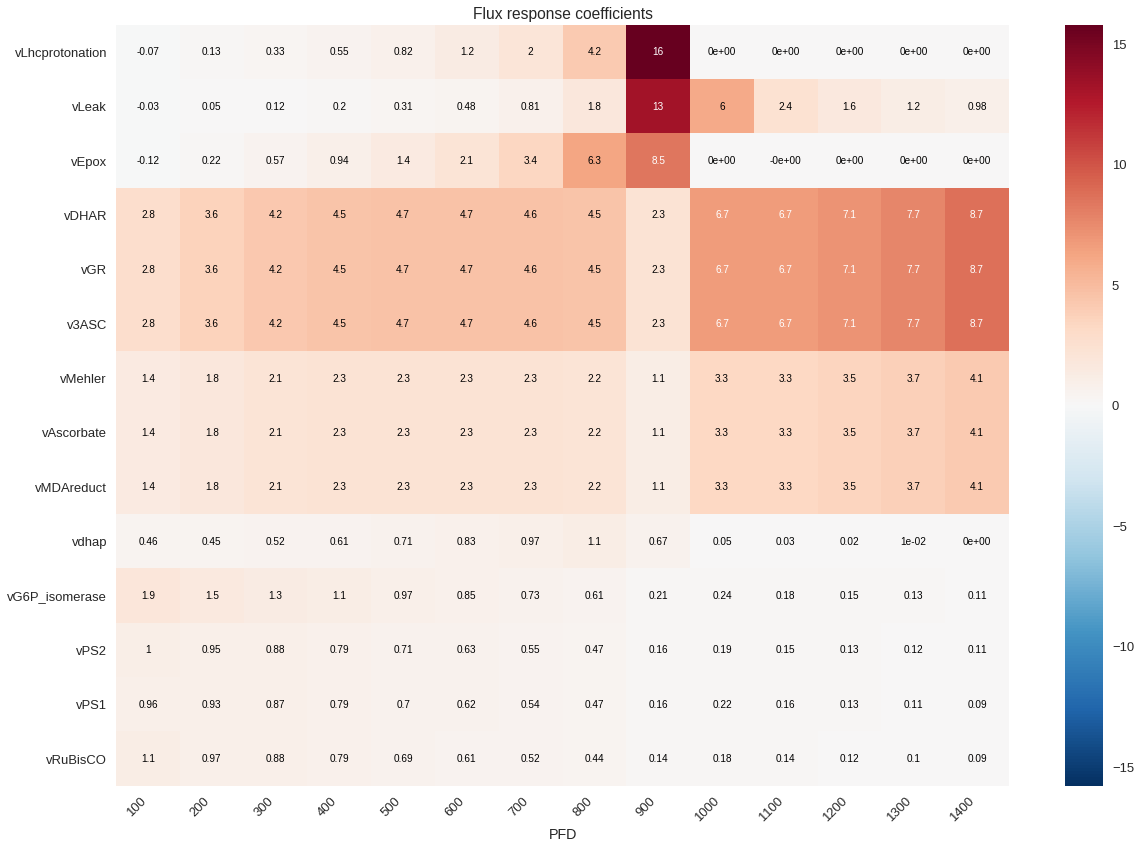

In [46]:
def plot_frcs(df) -> Figure:
    span = max(df.min().min(), df.max().max())
    fig, ax = plt.subplots(figsize=(20, len(df.columns)))
    mca.plot_coefficient_heatmap(
        df,
        title="Flux response coefficients",
        xlabel="PPFD",
        ax=ax,
        vmin=-span,
        vmax=span,
    )
    return fig


# frcs.loc[900].abs().sort_values(ascending=False)[:10]
# frcs["triose_export"] = frcs.loc[:, ["vdhap", "vgap", "vpga"]].sum(axis=1)

rxn_selection = [
    "vLhcprotonation",
    "vLeak",
    "vEpox",
    "vDHAR",  # produces GSSG
    "vGR",
    "v3ASC",
    "vMehler",
    "vAscorbate",
    "vMDAreduct",
    "vdhap",
    # "triose_export",  # exporter
    "vG6P_isomerase",
    #
    "vPS2",
    "vPS1",
    "vRuBisCO",
    # "vCyc",
]

_ = plot_frcs(frcs.loc[:, rxn_selection])

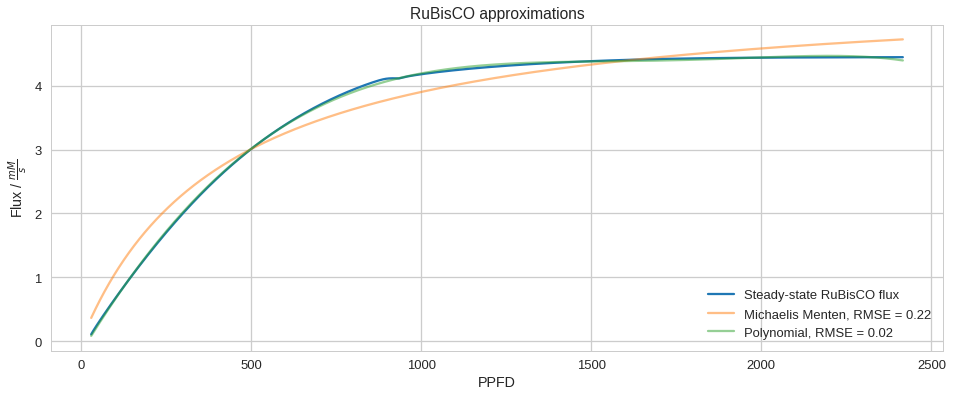

In [7]:
def plot_fit_mm_and_poly(
    ss_fluxes_by_pfd: pd.DataFrame,
    mmfit: Array,
    polyfit: Array,
    figsize: tuple[float, float] = (16, 6),
) -> Figure:
    x = ss_fluxes_by_pfd.index.to_numpy()
    y = ss_fluxes_by_pfd["vRuBisCO"].fillna(method="pad").to_numpy()
    y_mm = michaelis_menten(x, *mmfit)
    y_poly = np.polyval(polyfit, x)

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x, y, label="Steady-state RuBisCO flux")
    ax.plot(x, y_mm, alpha=0.5, label=f"Michaelis Menten, RMSE = {np.sqrt(np.mean(np.square(y - y_mm))):.2f}")  # type: ignore
    ax.plot(x, y_poly, alpha=0.5, label=f"Polynomial, RMSE = {np.sqrt(np.mean(np.square(y - y_poly))):.2f}")  # type: ignore
    ax.set_xlabel("PPFD")
    ax.set_ylabel(r"Flux / $\frac{mM}{s}$")
    ax.legend(loc="lower right")
    ax.set_title("RuBisCO approximations")

    return fig


mmfit, polyfit = fit_mm_and_poly(ss_fluxes_by_pfd, 5)
fig = plot_fit_mm_and_poly(ss_fluxes_by_pfd, mmfit, polyfit)
plt.savefig(IMG_PATH / "part1-rubisco-approximations.png", bbox_inches="tight", dpi=200)

In [22]:
# ss_concentrations_by_pfd.loc[:, ["SBP", "S7P", "F6P", "DHAP", "RU5P"]].plot()
# ss_concentrations_by_pfd.loc[:, ["RUBP"]].plot()

In [8]:
def plot_rubisco_approximations_prediction(
    experiment: pd.Series, figsize: tuple[float, float]
) -> Figure:
    fig, ax = plt.subplots(figsize=figsize)
    x = experiment.index[0] + pd.to_timedelta(v_ode.index, unit="s")
    y_true = v_ode["vRuBisCO"].sum()

    ax.plot(x, v_ode["vRuBisCO"], label="ODE")
    ax.plot(
        x,
        simulate_rubisco_with_dss(experiment, ss_fluxes_by_pfd),
        label=f"DSS, error = {abs((y_true - simulate_rubisco_with_dss(experiment, ss_fluxes_by_pfd).sum()) / y_true):.2%}",
    )
    ax.plot(
        x,
        simulate_rubisco_with_polyfit(experiment, polyfit),
        label=f"Polynomial, error = {abs((y_true - simulate_rubisco_with_polyfit(experiment, polyfit).sum()) / y_true):.2%}",
    )
    ax.plot(
        x,
        simulate_rubisco_with_mm(experiment, *mmfit),
        label=f"Michaelis-Menten, error = {abs((y_true - simulate_rubisco_with_mm(experiment, *mmfit).sum()) / y_true):.2%}",
    )
    ax.legend()
    ax.set_title("RuBisCO approximations")
    ax.set_ylabel("Flux / (mM/s)")
    return fig


_ = plot_rubisco_approximations_prediction(experiment, figsize=(16, 7))
plt.savefig(
    IMG_PATH / "part1-rubisco-approximations-prediction.png",
    bbox_inches="tight",
    dpi=200,
)

## Part 2: time steps

So far the model is still very data-hungry. Can we improve on that?
Let's start by using the mean of the data in given blocks of time.
For steps of 30 minutes we are already at roughly 4 % error and for 60 minute steps we are at 7 %. 

In [20]:
fig = plot_ss_rubisco_flux_per_pfd(
    v_ode,
    ss_fluxes_by_pfd,
    experiment,
    min_line=False,
    max_line=False,
    markers=True,
    figsize=(8, 8),
)
plt.savefig(
    IMG_PATH / "experiment-rubisco-by-pfd-with-markers.png", bbox_inches="tight", dpi=200
)

In [12]:
def plot_rubisco_error_per_step_size(
    v_ode: pd.DataFrame,
    df: pd.DataFrame,
    figsize: tuple[float, float] = (16, 6),
    ax: Axis | None = None,
    label: str | None = None,
) -> Figure:
    def relative(x: float, y: pd.Series) -> pd.Series:
        return (x - y) * 100 / x

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        ax.set(
            xlabel="Step size / min",
            ylabel="Error / %",
            title="Carboxylation prediction error by step size",
        )
    else:
        fig = ax.get_figure()
    ax.plot(relative(v_ode["vRuBisCO"].sum(), df.sum()).abs(), label=label)
    return fig

In [21]:
df = pd.DataFrame(
    {
        1: v_dss_1["vRuBisCO"],
        2: simulate_rubisco_with_dss(experiment, ss_fluxes_by_pfd, 2),
        5: simulate_rubisco_with_dss(experiment, ss_fluxes_by_pfd, 5),
        10: simulate_rubisco_with_dss(experiment, ss_fluxes_by_pfd, 10),
        20: simulate_rubisco_with_dss(experiment, ss_fluxes_by_pfd, 20),
        60: simulate_rubisco_with_dss(experiment, ss_fluxes_by_pfd, 60),
    }
)  # type: ignore

fig = plot_rubisco_error_per_step_size(v_ode, df, figsize=(8, 8))

# plt.savefig(IMG_PATH / "part2-error-by-step-size.png", bbox_inches="tight", dpi=200)

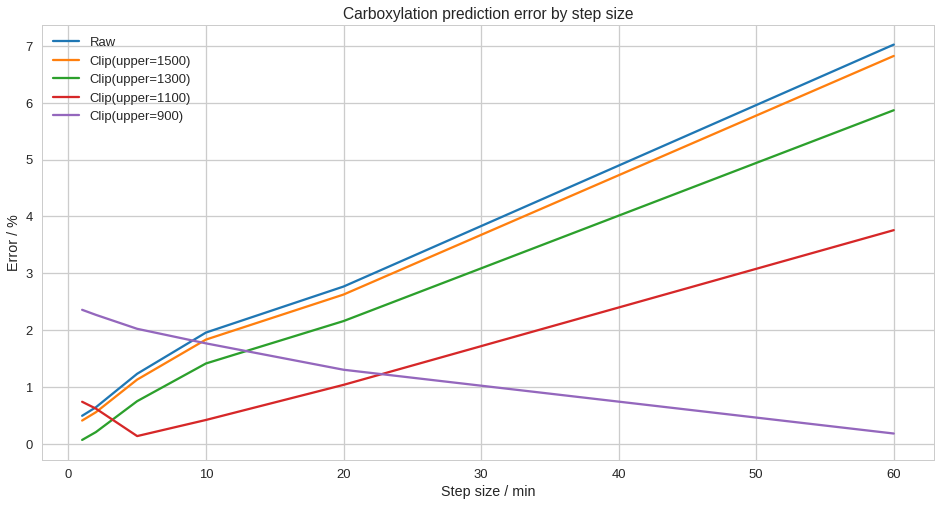

In [20]:
fig = plot_rubisco_error_per_step_size(v_ode, df, figsize=(16, 8), label="Raw")
ax = fig.axes[0]

for i in [
    1500,
    1300,
    1100,
    900,
    # 700,
    # 500,
]:
    df_clipped = pd.DataFrame(
        {
            1: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 1),
            2: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 2),
            # 3: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 3),
            # 4: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 4),
            5: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 5),
            # 6: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 6),
            # 7: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 7),
            # 8: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 8),
            # 9: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 9),
            10: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 10),
            20: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 20),
            60: simulate_rubisco_with_dss(experiment.clip(upper=i), ss_fluxes_by_pfd, 60),
            # 120: v_dss_120["vRuBisCO"],
        }
    )  # type: ignore
    plot_rubisco_error_per_step_size(v_ode, df_clipped, label=f"Clip(upper={i})", ax=ax)
ax.legend()

plt.savefig(
    IMG_PATH / "part2-error-by-step-size-clipped.png", bbox_inches="tight", dpi=200
)

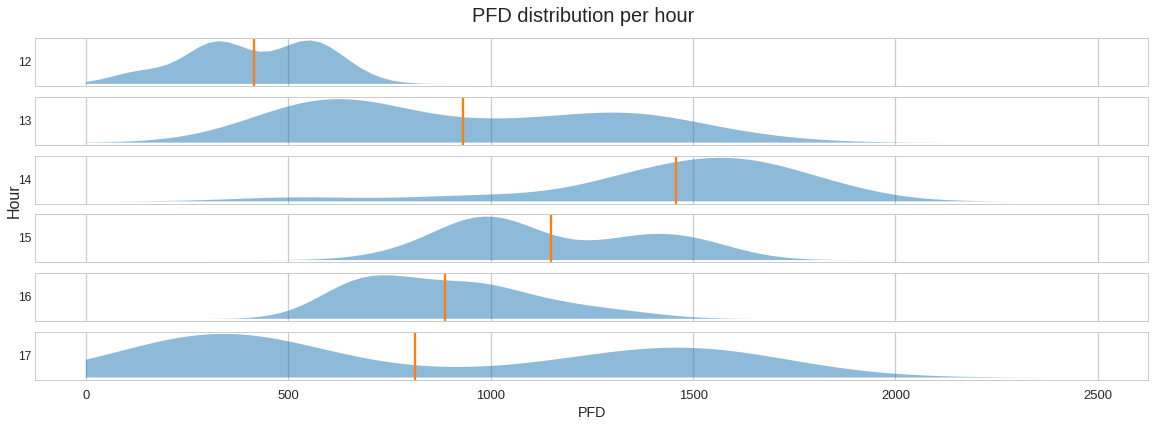

In [22]:
# PFD distribution per hour


def plot_pfd_distribution_per_hour(
    experiment: pd.Series,
    figsize: tuple[float, float] = (16, 6),
) -> Figure:
    df = pd.DataFrame(
        {
            "hour": experiment.index.hour,  # type: ignore
            "pfd": experiment.to_numpy(),
        }
    )

    fig, axs = plt.subplots(6, 1, figsize=figsize, sharex=True)

    for ax, (hour, gb) in zip(axs.flatten(), df.groupby("hour")):
        xs = np.linspace(0, 2500, 100)
        density = gaussian_kde(gb["pfd"])
        ax.fill_between(xs, density(xs), alpha=0.5)
        ax.axvline(gb["pfd"].mean(), color="C1")
        ax.set_yticks([])
        ax.set_ylabel(hour, rotation=0, ha="right", va="center", fontsize=12)

    axs.flatten()[-1].set_xlabel("PPFD")
    fig.suptitle("PPFD distribution per hour", fontsize=20)
    fig.text(0, 0.5, "Hour", rotation=90, fontsize=16)
    fig.tight_layout()
    return fig


fig = plot_pfd_distribution_per_hour(experiment)
plt.savefig(
    IMG_PATH / "part2-pfd-distribution-per-hour.png", bbox_inches="tight", dpi=200
)

In [23]:
# If you just take a single PFD over the whole experiment

# fig = plot_proximity_of_dss_per_pfd(experiment, v_ode, ss_fluxes_by_pfd)

In [24]:
# fig, axs = plot_dss_error_over_time(experiment, v_ode, v_dss_1, "Step size: 1 minute")
# plt.savefig(IMG_PATH / "fig02-01.png", bbox_inches="tight", dpi=100)

# fig, axs = plot_dss_error_over_time(experiment, v_ode, v_dss_10, "Step size: 10 minutes")
# plt.savefig(IMG_PATH / "fig02-10.png", bbox_inches="tight", dpi=100)

# fig, axs = plot_dss_error_over_time(experiment, v_ode, v_dss_60, "Step size: 60 minutes")
# plt.savefig(IMG_PATH / "fig02-60.png", bbox_inches="tight", dpi=100)

In [25]:
# fig = plot_proximity_of_dss_per_pfd(experiment, v_ode, ss_fluxes_by_pfd)

## Correct the weighted mean

In [26]:
# y_true = v_ode["vRuBisCO"].sum()
# f = interp1d(
#     v_dss_1.index, v_dss_1["vRuBisCO"].values, kind="cubic", fill_value="extrapolate"
# )


# def error_mm(pars: tuple[float, float], f, steps: pd.Series) -> float:
#     y_pred = 0
#     for t_start, pfd in steps.iteritems():
#         t_start = int(t_start)  # type: ignore
#         t_end = t_start + 60
#         v = f(michaelis_menten(pfd, *pars))
#         y_pred += v * (t_end - t_start)
#     return np.sqrt(np.mean(np.square(y_true - y_pred)))  # type: ignore


# def error_poly(pars: tuple[float, ...], f, steps) -> float:
#     y_pred = 0
#     for t_start, pfd in steps.iteritems():
#         t_start = int(t_start)  # type: ignore
#         t_end = t_start + 60
#         v = f(np.polyval(pars, pfd))
#         y_pred += v * (t_end - t_start)
#     return np.sqrt(np.mean(np.square(y_true - y_pred)))  # type: ignore


# pars_mm = minimize(
#     error_mm,
#     x0=(1000, 500),
#     bounds=[(0, None), (250, None)],
#     args=(
#         f,
#         get_simulation_steps(experiment, 1),
#     ),
# ).x

# min_poly = minimize(
#     error_poly,
#     x0=(1e-11, 1e-8, 1e-6, 1e-3, 500),
#     args=(
#         f,
#         get_simulation_steps(experiment, 1),
#     ),
# )
# pars_poly = min_poly.x

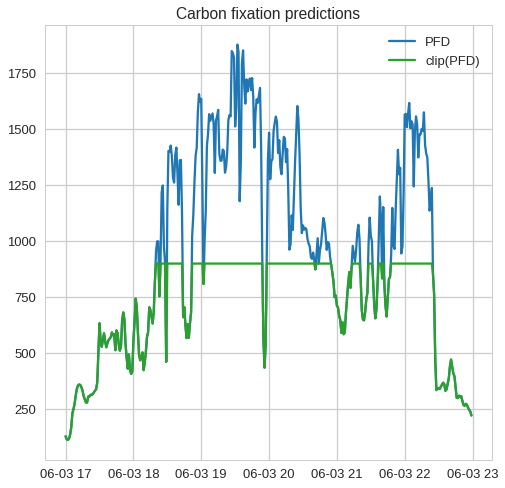

In [27]:
pars_poly = [5.0e-11, 1.0e-07, 1.0e-08, 1.0e-04, 485]


def plot_modified_pfd_data(experiment: pd.Series, figsize: tuple[float, float]) -> Figure:
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(experiment, label="PPFD")
    ax.plot(experiment.clip(upper=900), label="clip(PPFD)", color="C2")
    # ax.plot(michaelis_menten(experiment, *pars_mm), label="michaelis_menten(PFD)")
    # plt.plot(experiment.index, np.polyval(pars_poly, experiment), color="C3")
    ax.legend()
    ax.set_title("Carbon fixation predictions")
    return fig


_ = plot_modified_pfd_data(experiment, figsize=(8, 8))
plt.savefig(IMG_PATH / "part2-modified-pfd-data.png", bbox_inches="tight", dpi=200)

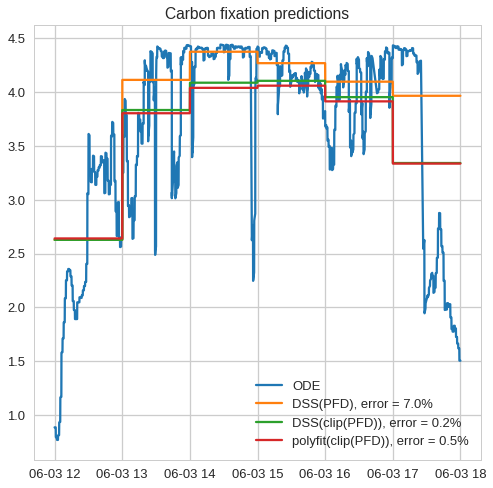

In [29]:
def plot_predictions_with_corrected_data(
    experiment: pd.Series, v_ode: pd.DataFrame, figsize: tuple[float, float]
) -> Figure:

    y_true = v_ode["vRuBisCO"].sum()

    y_pred_raw = simulate_dss_with_par(experiment, ss_fluxes_by_pfd, 60)["vRuBisCO"]
    y_pred_clip = simulate_dss_with_par(experiment.clip(upper=900), ss_fluxes_by_pfd, 60)[
        "vRuBisCO"
    ]
    y_pred_clip_poly = simulate_rubisco_with_polyfit(
        experiment.clip(upper=900), polyfit, 60
    )

    x = experiment.index[0] + pd.to_timedelta(v_ode.index, unit="s")

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x, v_ode["vRuBisCO"], label="ODE")
    ax.plot(
        x,
        y_pred_raw,
        label=f"DSS(PFD), error = {abs(y_true - y_pred_raw.sum()) / y_true:.1%}",
    )
    ax.plot(
        x,
        y_pred_clip,
        label=f"DSS(clip(PFD)), error = {abs(y_true - y_pred_clip.sum()) / y_true:.1%}",
    )
    ax.plot(
        x,
        y_pred_clip_poly,
        label=f"polyfit(clip(PFD)), error = {abs(y_true - y_pred_clip_poly.sum()) / y_true:.1%}",
    )

    ax.legend()
    ax.set_title("Carbon fixation predictions")
    return fig


plot_predictions_with_corrected_data(experiment, v_ode, figsize=(8, 8))
plt.savefig(IMG_PATH / "part2-modified-pfd-predictions.png", bbox_inches="tight", dpi=200)

## Check for all months


In [22]:
coverage_per_day = get_coverage_per_day(data_by_one_minute["2018":"2018"])
day_with_most_coverage = get_day_with_most_coverage(coverage_per_day)
valid_months = coverage_per_day.loc[day_with_most_coverage].dropna().index  # type: ignore
day_with_most_coverage

25

In [23]:
worker = partial(
    simulate_day_by_hours,
    model_fn=get_model,
    ss_concentrations_by_pfd=ss_concentrations_by_pfd,
    day_with_most_coverage=day_with_most_coverage,
    data_by_one_minute=data_by_one_minute,
)
# This takes roughly 5 minutes
experiments_split: dict[int, dict[int, Experiment]] = dict(
    process_map(worker, valid_months)
)

# flux_year = pd.concat(
#     i.ode_fluxes.set_index(
#         i.data.index[0] + pd.to_timedelta(i.ode_fluxes.index, unit="s")
#     )["vRuBisCO"]
#     for j in experiments_split.values()
#     for i in j.values()
# )

# worker = partial(
#     simulate_day_at_once,
#     model_fn=get_model,
#     ss_concentrations_by_pfd=ss_concentrations_by_pfd,
#     day_with_most_coverage=day_with_most_coverage,
#     data_by_one_minute=data_by_one_minute,
# )

# # This takes roughly 5 minutes
# experiments_continuous: dict[int, Experiment] = dict(process_map(worker, valid_months))

  0%|          | 0/11 [00:00<?, ?it/s]

In [24]:
def concat_data(experiments: dict[int, Experiment]) -> tuple[pd.Series, pd.Series]:
    pfd = []
    rubisco = []
    for i in experiments.values():
        pfd.append(i.data)
        rubisco.append(
            pd.Series(
                data=i.ode_fluxes["vRuBisCO"].values,
                index=i.data.index[0] + pd.to_timedelta(i.ode_fluxes.index, unit="s"),
            )
        )
    return pd.concat(pfd), pd.concat(rubisco)


# def concat_year(experiments_split: dict[int, dict[int, Experiment]]) -> tuple[pd.Series, pd.Series]:
#     pfds = []
#     odes = []
#     for e in experiments_split.values():
#         pfd, ode = concat_data(experiments_split[2])
#         pfds.append(pfd)
#         odes.append(ode)
#     return pd.concat(pfds), pd.concat(odes)


def get_predictions_per_month(
    experiments_split: dict[int, dict[int, Experiment]],
    ss_fluxes_by_pfd: pd.DataFrame,
    polyfit: Array,
) -> pd.DataFrame:
    predictions = {}
    for month, data in experiments_split.items():
        pfd, rubisco = concat_data(data)
        predictions[month] = {
            "ode": rubisco.sum(),
            # "dss": simulate_rubisco_with_dss(pfd, ss_fluxes_by_pfd, 60).sum(),
            "polyfit": simulate_rubisco_with_polyfit(pfd, polyfit, 60).sum(),
            # "dss clipped @ 800": simulate_rubisco_with_dss(
            #     pfd.clip(upper=800), ss_fluxes_by_pfd, 60
            # ).sum(),
            # "dss clipped @ 900": simulate_rubisco_with_dss(
            #     pfd.clip(upper=900), ss_fluxes_by_pfd, 60
            # ).sum(),
            # "dss clipped @ 1000": simulate_rubisco_with_dss(
            #     pfd.clip(upper=1000), ss_fluxes_by_pfd, 60
            # ).sum(),
            # "dss clipped @ 1100": simulate_rubisco_with_dss(
            #     pfd.clip(upper=1100), ss_fluxes_by_pfd, 60
            # ).sum(),
            "polyfit clipped @ 800": simulate_rubisco_with_polyfit(
                pfd.clip(upper=800), polyfit, 60
            ).sum(),
            "polyfit clipped @ 900": simulate_rubisco_with_polyfit(
                pfd.clip(upper=900), polyfit, 60
            ).sum(),
            "polyfit clipped @ 1000": simulate_rubisco_with_polyfit(
                pfd.clip(upper=1000), polyfit, 60
            ).sum(),
            "polyfit clipped @ 1100": simulate_rubisco_with_polyfit(
                pfd.clip(upper=1100), polyfit, 60
            ).sum(),
        }
    return pd.DataFrame(predictions).T

In [25]:
predictions = get_predictions_per_month(experiments_split, ss_fluxes_by_pfd, polyfit)

In [26]:
def plot_errors_per_month(
    predictions: pd.DataFrame,
    selection: list[str] | None = None,
    figsize: tuple[float, float] = (16, 6),
    legend_kwargs: dict[str, str | float] | None = None,
) -> Figure:
    month_names = get_month_names()

    # Absolute yearly error
    total = predictions.sum()
    abs_yearly_error = ((total - total["ode"]) / total["ode"]).drop("ode")  # type: ignore

    # Relative error per month
    rel_errors_by_month = (
        (predictions.T - predictions.ode) * 100 / predictions.ode
    ).T.drop("ode", axis=1)
    if selection is not None:
        rel_errors_by_month = rel_errors_by_month.loc[:, selection]

    fig, ax = plt.subplots(figsize=figsize)
    rel_errors_by_month.plot(kind="bar", ylabel="Error / %", ax=ax)
    ax.set_xticklabels([month_names[i] for i in rel_errors_by_month.index])
    ax.set_title("Relative total error per day (60 min steps)")

    if legend_kwargs is None:
        legend_kwargs = {}
    ax.legend(
        [f"{i}, total = {abs_yearly_error[i]:.1%}" for i in rel_errors_by_month.columns],
        **legend_kwargs,
    )
    ax.set_ylim(-15, 15)
    return fig

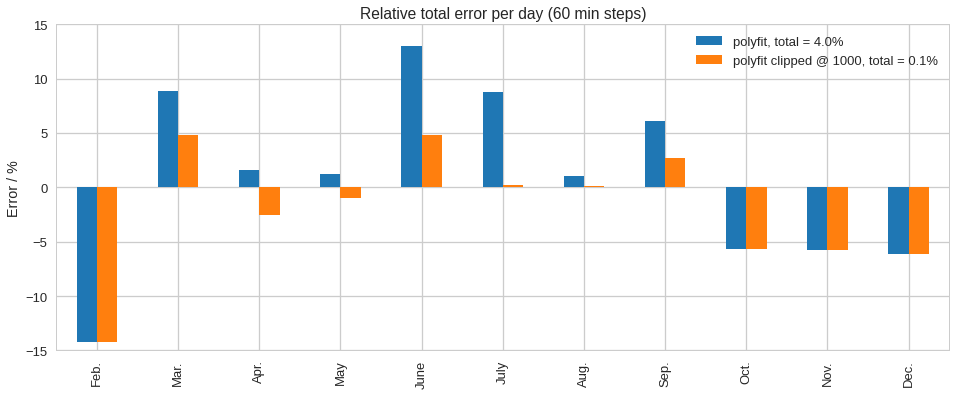

In [29]:
_ = plot_errors_per_month(
    predictions,
    # selection=["dss", "polyfit", "dss clipped @ 900", "polyfit clipped @ 1000"],
    selection=["polyfit", "polyfit clipped @ 1000"],
)
plt.savefig(
    IMG_PATH / "part2-absolute-total-error-per-day-selection.png",
    bbox_inches="tight",
    dpi=200,
)

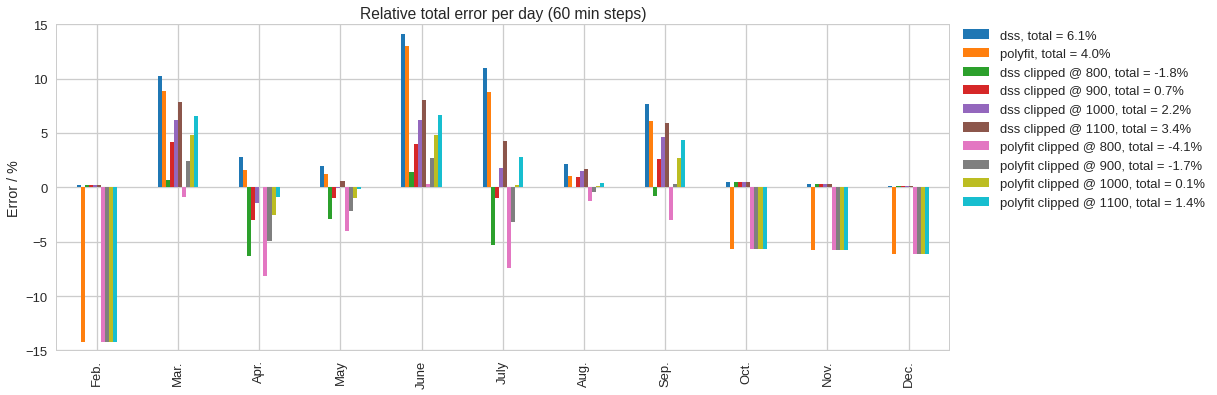

In [42]:
fig = plot_errors_per_month(
    predictions,
    legend_kwargs=dict(loc="upper left", bbox_to_anchor=(1.01, 1), borderaxespad=0),
)
plt.savefig(
    IMG_PATH / "part2-absolute-total-error-per-day-all.png", bbox_inches="tight", dpi=200
)

In [33]:
# fig = plot_error_of_mean_pfd_by_month_and_hour(experiments_split, ss_fluxes_by_pfd)
# plt.savefig(IMG_PATH / "fig9.png", bbox_inches="tight", dpi=100)

In [34]:
# fig = plot_error_of_mean_pfd_per_step_size_per_month_per_hour(experiments_split, ss_fluxes_by_pfd)

In [35]:
# _ = plot_error_per_pfd_per_month_per_hour(experiments_split, ss_fluxes_by_pfd)
# plt.savefig(IMG_PATH / "fig10.png", bbox_inches="tight", dpi=100)

In [36]:
# proximity_5 = {}
# proximity_10 = {}
# proximity_15 = {}

# for month, experiments_by_hour in experiments_split.items():
#     for hour, experiment in experiments_by_hour.items():
#         if experiment is not None and (9 <= hour <= 20):
#             rel_diff_rubisco = get_relative_difference_carbon_fixation(
#                 experiment.ode_fluxes, ss_fluxes_by_pfd
#             )
#             proximity_5.setdefault(month, {}).setdefault(hour, count_proximity(rel_diff_rubisco, 5))
#             proximity_10.setdefault(month, {}).setdefault(hour, count_proximity(rel_diff_rubisco, 10))
#             proximity_15.setdefault(month, {}).setdefault(hour, count_proximity(rel_diff_rubisco, 15))

In [37]:
# fig = plot_proximity_per_pfd_per_hour_per_month(proximity_5, "5% proximity per PFD")
# plt.savefig(IMG_PATH / "fig6.png", bbox_inches="tight", dpi=100)

In [38]:
# def get_proximitiy_of_mean_pfd(
#     experiments_split: dict[int, dict[int, Experiment]],
#     proximities: dict[int, dict[int, pd.DataFrame]],
# ) -> dict[int, pd.Series]:
#     mean_proximity = {}
#     for month, proximity_per_hour in proximities.items():
#         mean_proximity[month] = pd.Series(
#             {
#                 hour: proximities[round(experiments_split[month][hour].data.mean())]
#                 for hour, proximities in proximity_per_hour.items()
#             }
#         )
#     return mean_proximity

# mean_proximity_5 = get_proximitiy_of_mean_pfd(experiments_split, proximity_5)
# mean_proximity_10 = get_proximitiy_of_mean_pfd(experiments_split, proximity_10)
# mean_proximity_15 = get_proximitiy_of_mean_pfd(experiments_split, proximity_15)

# fig = plot_proximity_of_mean_pfd_per_hour_per_month(mean_proximity_5, "5% proximity of mean PFD")
# plt.savefig(IMG_PATH / "fig11.png", bbox_inches="tight", dpi=100)

# # fig = plot_absolute_error_of_mean_pfd_per_month_box(experiments_split, ss_fluxes_by_pfd)
# # plt.savefig(IMG_PATH / "fig12.png", bbox_inches="tight", dpi=100)

# fig = plot_absolute_error_of_mean_pfd_per_month_bar(experiments_split, ss_fluxes_by_pfd)
# plt.savefig(IMG_PATH / "fig13.png", bbox_inches="tight", dpi=100)

## Bonus: Distribution

In [10]:
# Using distribution instead of mean value

short_experiment = day.between_time("12:00", "12:59").round(decimals=0)

s = Simulator(get_model(short_experiment.iloc[0]))
s.initialise(y_ss)
result = simulate_ode_with_par(s, short_experiment)
v_ode = cast(SimulationResult, result).fluxes
fig = plot_pfd_distribution_and_mean(short_experiment)
fig = plot_error_distribution_by_sample_size(short_experiment, v_ode, ss_fluxes_by_pfd)
plt.savefig(IMG_PATH / "bonus-error-by-sample-size.png", bbox_inches="tight", dpi=100)

In [151]:
# def fn(s, vmax):
#     return s * vmax


# def inverse(v, vmax):
#     return v / vmax


# vmax = 1

# x = np.linspace(0, 10)
# y = fn(x, vmax)

# x2 = np.linspace(0, 4)
# y2_xmean = fn(x2.mean(), vmax)
# y2_ymean = fn(x2, vmax).mean()

# fig, ax = plt.subplots()
# ax.plot(x, y)
# ax.plot(x2.mean(), y2_xmean, "o", label="mass_action(|x|, vmax, km)")
# ax.plot(inverse(y2_ymean, vmax), y2_ymean, "o", label="|mass_action(x, vmax, km)|")
# ax.axvspan(x2[0], x2[-1], color="black", alpha=0.1)
# ax.set_title(f"Error: {(y2_xmean - y2_ymean) / vmax:.1%}")
# ax.legend()
# plt.show()

## Bonus: error of saturating functions (mean)

In [4]:
def fn(s, vmax, km):
    return s * vmax / (s + km)


def inverse(v, vmax, km):
    # import sympy
    # x = sympy.Symbol("x")
    # y = sympy.Symbol("y")
    # vmax = sympy.Symbol("vmax")
    # km = sympy.Symbol("km")
    # eq = sympy.Eq(y, (x * vmax / (x + km)))
    # sympy.solve(eq, x)
    return km * v / (vmax - v)


km = 0.5
vmax = 1

x = np.linspace(0, 10)
y = fn(x, vmax, km)

x2 = np.linspace(0, 3)
y2_xmean = fn(x2.mean(), vmax, km)
y2_ymean = fn(x2, vmax, km).mean()

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x2.mean(), y2_xmean, "o", label="michaelis_menten(|x|, vmax, km)")
ax.plot(
    inverse(y2_ymean, vmax, km), y2_ymean, "o", label="|michaelis_menten(x, vmax, km)|"
)
ax.axvspan(x2[0], x2[-1], color="black", alpha=0.1)
ax.set_title(f"Error: {(y2_xmean - y2_ymean) / vmax:.1%}")


# ax.plot(x, x * 0.1)
# ax.plot(x, inverse(fn(x, vmax, km), vmax, km))
ax.legend()
plt.show()

In [5]:
plt.plot(x, (x - fn(x, vmax, km)))

In [179]:
inverse(x2.mean(), 1, 0.5)

-1.5

In [163]:
n = 500
x_start = np.linspace(0, 10, n)
x_end = np.linspace(0, 10, n)
error = np.full((n, n), np.nan, dtype="float")
for i, s in enumerate(x_start):
    for j, e in enumerate(x_end):
        if s < e:
            x = np.linspace(s, e, 100)
            y_pred = fn(x.mean(), vmax, km)
            y_true = fn(x, vmax, km).mean()
            error[i, j] = (y_pred - y_true) * 100 / y_true

fig, ax = plt.subplots()
ax.grid(False)
mesh = ax.pcolormesh(error.T, cmap="viridis")
ax.set_xlabel("x start")
ax.set_ylabel("x stop")
ax.set_title(f"Error of using data mean vs prediction mean for km = {km}")
fig.colorbar(mesh, label="Error / %")
plt.savefig(
    IMG_PATH / "bonus-error-data-mean-vs-prediction-mean", bbox_inches="tight", dpi=100
)

## Bonus: finding exact weighted mean to counteract PPFD

In [70]:
def fn(s, vmax, km):
    return s * vmax / (s + km)


km = 0.5
vmax = 1


def residual(pars: list[float]):
    error = 0

    for areas in ([0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [7, 8], [9, 10]):
        x = np.linspace(*areas)
        y_true = fn(x, vmax, km).mean()
        x_changed = np.polyval(pars, x) * x
        y_pred = fn(x_changed.mean(), vmax, km)
        error += abs(y_pred - y_true)
    return error


fit = minimize(
    residual,
    x0=(1, 1, 1),
    method="L-BFGS-B",
).x

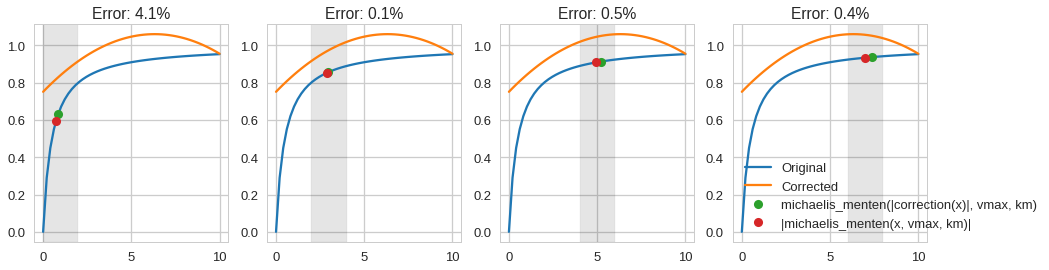

In [74]:
areas = ((0, 2), (2, 4), (4, 6), (6, 8))
fig, axs = plt.subplots(1, len(areas), figsize=(len(areas) * 4, 4))

for ax, (start, stop) in zip(axs.ravel(), areas):
    x2 = np.linspace(start, stop)
    x2_mean_corrected = (np.polyval(fit, x2) * x2).mean()
    y2_xmean = fn(x2_mean_corrected, vmax, km)
    y2_ymean = fn(x2, vmax, km).mean()
    ax.plot(x, y, label="Original")
    ax.plot(x, np.polyval(fit, x), label="Corrected")
    ax.plot(
        x2_mean_corrected,
        y2_xmean,
        "o",
        label="michaelis_menten(|correction(x)|, vmax, km)",
    )
    ax.plot(
        inverse(y2_ymean, vmax, km),
        y2_ymean,
        "o",
        label="|michaelis_menten(x, vmax, km)|",
    )
    ax.axvspan(x2[0], x2[-1], color="black", alpha=0.1)
    ax.set_title(f"Error: {(y2_xmean - y2_ymean) / vmax:.1%}")
ax.legend()
plt.show()